In [1]:
import torch
from torch import nn
import cv2
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tqdm
from torchvision import datasets, transforms
import wandb
from torch.utils.data import DataLoader
from sklearn.preprocessing import Normalizer

## Loading and Preprocessing Dataset

In [2]:
df = pd.read_csv('./Iris.csv')

In [3]:
len(df)

150

In [4]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df.drop(columns=['Id'], inplace=True)
label_encoder = LabelEncoder()

In [6]:
df['Species'] = label_encoder.fit_transform(df['Species'])

### Loading only the first 50 rows (Iris-Setosa samples)

In [7]:
X = torch.from_numpy(df.iloc[:50, :df.shape[1] -1].to_numpy())
Y = torch.from_numpy(df.iloc[:50, df.shape[1] -1].to_numpy())

In [8]:
# converting label 0s to label 1s
Y[:] = 1
Y

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])

## Generator Discriminator Network Definition

In [9]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
        )
        
    def forward(self, x):
        return self.fc(x)

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(0.2),
            nn.Linear(256, 128),
            nn.ReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.fc(x)


In [10]:
# shape of latent dimension to pass through Generator for fake samples
z_dim = 100

In [11]:
dn = Discriminator(input_size=4) # 4 => size of iris feature vector
gn = Generator(input_size=z_dim, output_size=4) # z_dim -> iris feature vector

In [12]:
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(dn.parameters(), lr=6e-4)
g_optimizer = torch.optim.Adam(gn.parameters(), lr=6e-4)

In [13]:
epochs = 10000

random_data = torch.rand(X.shape[0], z_dim)
real_data = X

fake_labels = torch.zeros_like(random_data[:, 0]).float()
truth_labels = torch.ones_like(real_data[:, 0]).float()


### Generated fake samples before generator training

In [14]:
# generating fake samples before training the generator
gn(random_data)

tensor([[-0.0152,  0.0227,  0.0653, -0.0416],
        [-0.0274, -0.0168,  0.0863, -0.0147],
        [-0.0067,  0.0545,  0.0525, -0.0052],
        [-0.0096,  0.0013,  0.1146, -0.0380],
        [-0.0182,  0.0268,  0.0476, -0.0206],
        [-0.0144,  0.0486,  0.0629, -0.0186],
        [-0.0457,  0.1095,  0.0040,  0.0143],
        [-0.0014,  0.0148,  0.0886,  0.0324],
        [-0.0013,  0.0897,  0.0788, -0.0440],
        [-0.0145,  0.0952,  0.0104, -0.0017],
        [-0.0081,  0.0638,  0.0861, -0.0154],
        [-0.0403,  0.1279,  0.0423, -0.0266],
        [-0.0351,  0.0631,  0.0231, -0.0158],
        [-0.0343,  0.0192,  0.0909, -0.0398],
        [-0.0308,  0.0085,  0.0626, -0.0202],
        [-0.0327,  0.0924,  0.0354, -0.0218],
        [ 0.0284,  0.0692,  0.0767, -0.0106],
        [-0.0481,  0.0536,  0.0559, -0.0384],
        [-0.0349,  0.0468,  0.0649, -0.0165],
        [-0.0632,  0.0041,  0.0996, -0.0123],
        [-0.0400,  0.1016,  0.0267, -0.0166],
        [-0.0594,  0.0112,  0.0692

In [15]:
epochs = 5000
for _ in range(epochs):

    d_optimizer.zero_grad()
    outputs = dn(real_data.float()).view(-1)
    d_loss_truth = loss_fn(outputs, truth_labels.float())
    
    random_data = torch.randn(X.shape[0], z_dim)
    fake_data = gn(random_data).float()
    outputs = dn(fake_data).view(-1)
    d_loss_fake = loss_fn(outputs, fake_labels.float())
    
    d_loss = d_loss_truth + d_loss_fake
    
    d_loss.backward()
    d_optimizer.step()
    d_optimizer.zero_grad()
    
    g_optimizer.zero_grad()
    random_data = torch.randn(X.shape[0], z_dim)
    fake_data = gn(random_data)
    
    outputs = dn(fake_data).view(-1)
    g_loss = loss_fn(outputs, truth_labels.float())
    
    g_loss.backward()
    g_optimizer.step()
    g_optimizer.zero_grad()
    print(f'Epoch {_ + 1} ; Discriminator Loss {d_loss} ; Generator Loss {g_loss}')
    

    

Epoch 1 ; Discriminator Loss 1.4730291366577148 ; Generator Loss 0.6891250014305115
Epoch 2 ; Discriminator Loss 1.2844452857971191 ; Generator Loss 0.6864509582519531
Epoch 3 ; Discriminator Loss 1.144016146659851 ; Generator Loss 0.683408260345459
Epoch 4 ; Discriminator Loss 1.0431104898452759 ; Generator Loss 0.6754394769668579
Epoch 5 ; Discriminator Loss 0.9717127084732056 ; Generator Loss 0.6702302694320679
Epoch 6 ; Discriminator Loss 0.9237238168716431 ; Generator Loss 0.6589176058769226
Epoch 7 ; Discriminator Loss 0.8996321558952332 ; Generator Loss 0.6469769477844238
Epoch 8 ; Discriminator Loss 0.8777841329574585 ; Generator Loss 0.6290169954299927
Epoch 9 ; Discriminator Loss 0.8822665810585022 ; Generator Loss 0.6220685243606567
Epoch 10 ; Discriminator Loss 0.8884514570236206 ; Generator Loss 0.5990477800369263
Epoch 11 ; Discriminator Loss 0.9084804058074951 ; Generator Loss 0.5777091383934021
Epoch 12 ; Discriminator Loss 0.9134601354598999 ; Generator Loss 0.56923079

In [16]:
generated_data = gn(torch.randn(X.shape[0], z_dim))

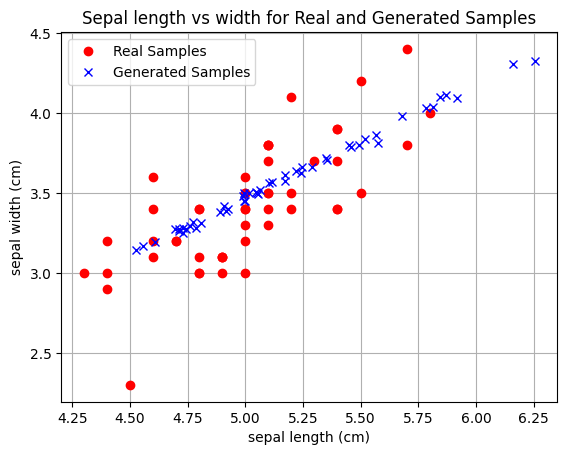

In [17]:
# plotting iris setosa length vs width features
# for real vs generated samples
plt.grid()
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.plot(X[:, 0], X[:, 1], 'ro')
plt.plot(generated_data[:, 0].detach().numpy(), generated_data[:, 1].detach().numpy(), 'bx')
plt.legend(['Real Samples', 'Generated Samples'])
plt.title('Sepal length vs width for Real and Generated Samples')
plt.show()

In [18]:
real_data

tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [4.6000, 3.1000, 1.5000, 0.2000],
        [5.0000, 3.6000, 1.4000, 0.2000],
        [5.4000, 3.9000, 1.7000, 0.4000],
        [4.6000, 3.4000, 1.4000, 0.3000],
        [5.0000, 3.4000, 1.5000, 0.2000],
        [4.4000, 2.9000, 1.4000, 0.2000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [5.4000, 3.7000, 1.5000, 0.2000],
        [4.8000, 3.4000, 1.6000, 0.2000],
        [4.8000, 3.0000, 1.4000, 0.1000],
        [4.3000, 3.0000, 1.1000, 0.1000],
        [5.8000, 4.0000, 1.2000, 0.2000],
        [5.7000, 4.4000, 1.5000, 0.4000],
        [5.4000, 3.9000, 1.3000, 0.4000],
        [5.1000, 3.5000, 1.4000, 0.3000],
        [5.7000, 3.8000, 1.7000, 0.3000],
        [5.1000, 3.8000, 1.5000, 0.3000],
        [5.4000, 3.4000, 1.7000, 0.2000],
        [5.1000, 3.7000, 1.5000, 0.4000],
        [4.6000, 3.6000, 1.0000, 0.2000],
        [5.1000, 3.3000, 1.7000, 0

In [19]:
generated_data

tensor([[4.7319, 3.2815, 1.6759, 0.1761],
        [4.7861, 3.2819, 1.6938, 0.1834],
        [4.9899, 3.4788, 1.7701, 0.1759],
        [5.7830, 4.0331, 2.0427, 0.1870],
        [4.6071, 3.1951, 1.6335, 0.1743],
        [4.5577, 3.1673, 1.6102, 0.1754],
        [4.8887, 3.3780, 1.7221, 0.1848],
        [5.5765, 3.8138, 1.9585, 0.1999],
        [5.8124, 4.0340, 2.0472, 0.2007],
        [5.3531, 3.7078, 1.8995, 0.1829],
        [4.7286, 3.2472, 1.6764, 0.1816],
        [5.2400, 3.6238, 1.8521, 0.1909],
        [6.2545, 4.3262, 2.2016, 0.2063],
        [4.7753, 3.3161, 1.6894, 0.1757],
        [5.6783, 3.9837, 2.0106, 0.1860],
        [5.1737, 3.6132, 1.8302, 0.1816],
        [4.5259, 3.1449, 1.6023, 0.1711],
        [5.0145, 3.4975, 1.7731, 0.1792],
        [6.1593, 4.3033, 2.1758, 0.1900],
        [5.2214, 3.6390, 1.8485, 0.1827],
        [4.9270, 3.3965, 1.7431, 0.1807],
        [4.9158, 3.3899, 1.7345, 0.1841],
        [4.6943, 3.2755, 1.6614, 0.1767],
        [5.3494, 3.7180, 1.8900, 0